In [1]:
#If you have not already installed climetlab & climetlab-maelstrom-nogwd
!pip install climetlab
!pip install climetlab-maelstrom-nogwd

In [2]:
import climetlab as cml

### Data in this dataset can be reference by dataset (preselected by the authors) or by forecast start date.
### A list of dates can also be passed to date.

In [5]:
cmlds = cml.load_dataset('maelstrom-nogwd',date='2015-01-01')
##or 
#cmlds = cml.load_dataset('maelstrom-nogwd',dataset='tier-1')

2015-01-01.nc:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

multisource before:  [Url(https://storage.ecmwf.europeanweather.cloud/NOGWD_L91_PUBLIC/nc/2015-01-01.nc)]
multisource after :  [Url(https://storage.ecmwf.europeanweather.cloud/NOGWD_L91_PUBLIC/nc/2015-01-01.nc)]


### Print list of all possible dates in the dataset

In [9]:
print(cmlds.all_datelist)

['2015-01-01', '2015-01-31', '2015-03-02', '2015-04-01', '2015-05-01', '2015-05-31', '2015-06-30', '2015-07-30', '2015-08-29', '2015-09-28', '2015-10-28', '2015-11-27', '2016-02-25', '2016-06-24', '2016-12-21', '2017-02-19', '2017-07-19', '2017-11-16']


### Use to_xarray to get an x-array view of the data

In [10]:
ds = cmlds.to_xarray()
print(ds)

merging UrlPattern(Url(https://storage.ecmwf.europeanweather.cloud/NOGWD_L91_PUBLIC/nc/2015-01-01.nc))
<xarray.Dataset>
Dimensions:  (examples: 2355840, input_features: 191, output_features: 126)
Dimensions without coordinates: examples, input_features, output_features
Data variables:
    x        (examples, input_features) float32 dask.array<chunksize=(2355840, 191), meta=np.ndarray>
    y        (examples, output_features) float32 dask.array<chunksize=(2355840, 126), meta=np.ndarray>


For this dataset data has been preprocessed into the inputs, x, and outputs, y.

x has shape (number_of_examples,number_of_input_features), with number_of_input_features = 191.

x is comprised of profiles of u,v winds & temperature (63 vertical layers each) plus the surface pressure and surface geopotential (63*3+2 = 191).

y has shape (number_of_examples,number_of_output_features), with number_of_input_features = 126.


In the NOGWD dataset we are seeking to predict the time increments to the wind fields (du/dt & dv/dt, 63 layers each) resulting from non-orographic gravity waves.

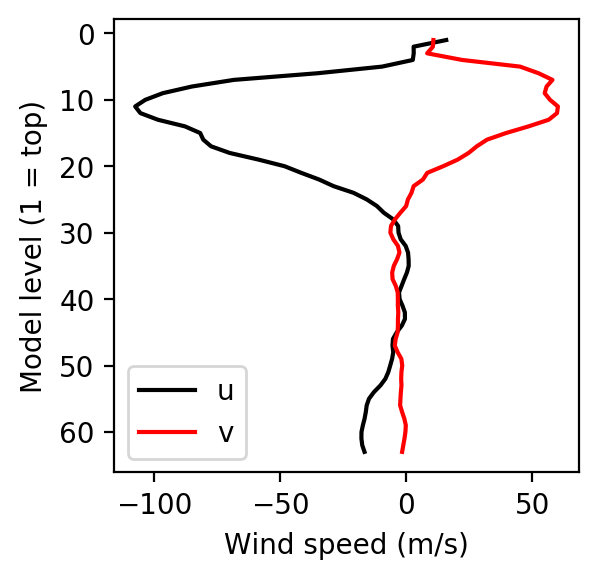

In [62]:
import matplotlib.pyplot as plt
fig=plt.figure(dpi=200,figsize=(3,3))
ax = fig.subplots()
ax.plot(ds['x'][0,:63],range(1,64),'k',label='u')
ax.plot(ds['x'][0,63:2*63],range(1,64),'r',label='v')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Model level (1 = top)')
ax.invert_yaxis()
plt.legend()

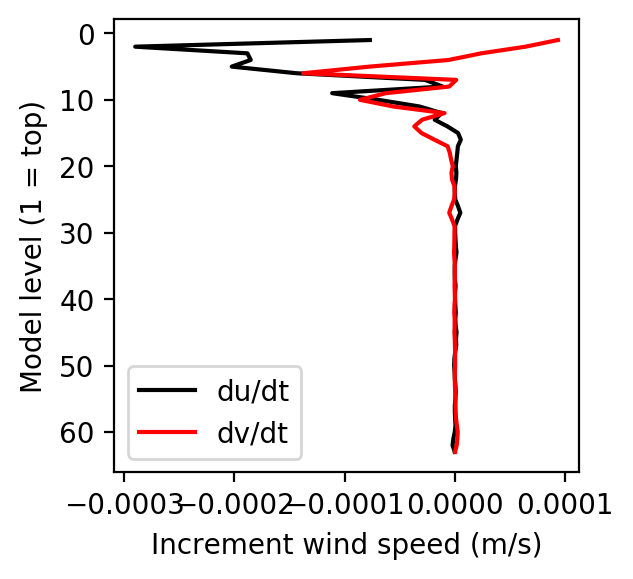

In [63]:
import matplotlib.pyplot as plt
fig=plt.figure(dpi=200,figsize=(3,3))
ax = fig.subplots()
ax.plot(ds['y'][1000,:63],range(1,64),'k',label='du/dt')
ax.plot(ds['y'][1000,63:2*63],range(1,64),'r',label='dv/dt')
plt.xlabel('Increment wind speed (m/s)')
plt.ylabel('Model level (1 = top)')
ax.invert_yaxis()
plt.legend()

# ML example
For the tutorial we will bring the x-array datasets into memory and standardise the inputs by subtracting the mean and dividing by the standard deviation.

We'll build a very simple fully connected neural network. MSE is an appropriate loss function for our problem.

To test for overfitting we can select a different date set and load in a validation dataset.

In [58]:
x = ds['x']
y = ds['y'].values #extracts the array from the x-array object

x = (x - x.mean(axis=0))/x.std(axis=0)

x = x.values
# Note that because the outputs are small we will get very small loss values. 
# We normalising the outputs to ensure our gradient descent increments are 
# larger than the smallest representable floats.
# Try yourself without this step and note that the predictions are much worse.
y = y * 10**3

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

inputs = Input(x.shape[1])
dense = Dense(256,activation='tanh')(inputs)
for i in range(3):
    dense = Dense(256,activation='tanh')(dense)
output = Dense(y.shape[1],activation='linear')(dense)

model = Model(inputs,output)
model.compile(optimizer=Adam(lr=10**(-4)),loss='mse')


In [59]:
model.fit(x,y,batch_size=256,epochs=10)


Train on 2355840 samples
Epoch 1/10
2355840/2355840 [==============================] - 78s 33us/sample - loss: 5.3337e-04
Epoch 2/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 3.4711e-04
Epoch 3/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 3.1542e-04
Epoch 4/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.9697e-04
Epoch 5/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.8420e-04
Epoch 6/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.7490e-04
Epoch 7/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.6760e-04
Epoch 8/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.6138e-04
Epoch 9/10
2355840/2355840 [==============================] - 49s 21us/sample - loss: 2.5635e-04
Epoch 10/10
2355840/2355840 [==============================] - 56s 24us/sample - loss: 2.5202e-04


In [60]:
y_pred = model.predict(x)

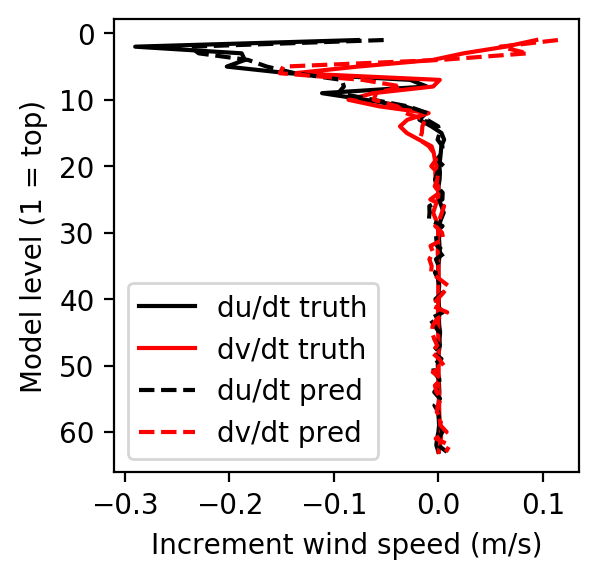

In [61]:
fig=plt.figure(dpi=200,figsize=(3,3))
ax = fig.subplots()
ax.plot(y[1000,:63],range(1,64),'k-',label='du/dt truth')
ax.plot(y[1000,63:2*63],range(1,64),'r-',label='dv/dt truth')

ax.plot(y_pred[1000,:63],range(1,64),'k--',label='du/dt pred')
ax.plot(y_pred[1000,63:2*63],range(1,64),'r--',label='dv/dt pred')

plt.xlabel('Increment wind speed (m/s)')
plt.ylabel('Model level (1 = top)')
ax.invert_yaxis()
plt.legend()

We have produced a fairly sensible prediction, capturing the approximate maxima, but there is room for improvement, note all the noise at the bottom of the atmosphere.